# Solution Overview

In [33]:
# Import necessary modules
from src import *
from PIL import Image

## 1.1 Data Preprocessing

### Generate segmentation masks with ids using the rgb colored masks

In [2]:
labeled_images_path = 'data/train'
class_dict = {
    1: (0, 77, 38),
    2: (255, 255, 255),
    3: (203, 20, 20),
    4: (191, 191, 147),
    5: (133, 223, 246),
    6: (159, 157, 12),
    7: (230, 193, 156),
    8: (139, 87, 42),
    9: (200, 200, 200),
}

Run the create_gt_images function (only once) to create the labeled images in npy format
This function is located in src/my_utils.py

In [3]:
# create_gt_images(labeled_images_path, class_dict)

### Explore the labeled dataset sizes and class distribution

Exploring 340 labeled images...


100%|██████████| 340/340 [00:00<00:00, 26134.17it/s]


Image Dimension Statistics:
max_width: 582.00
max_height: 2552.00
mean_width: 368.91
mean_height: 1796.93
std_width: 94.23
std_height: 420.33
median_width: 352.00
median_height: 1756.00


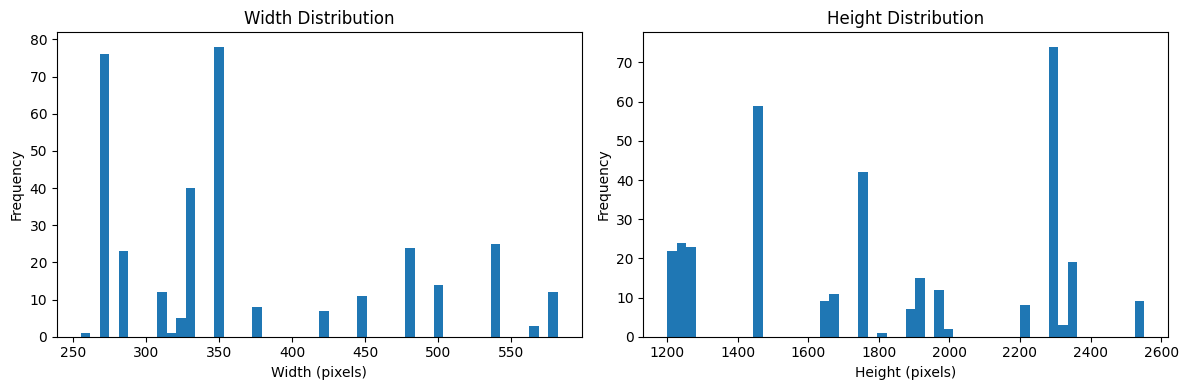

Processing 340 ground truth files...


100%|██████████| 340/340 [00:02<00:00, 125.16it/s]


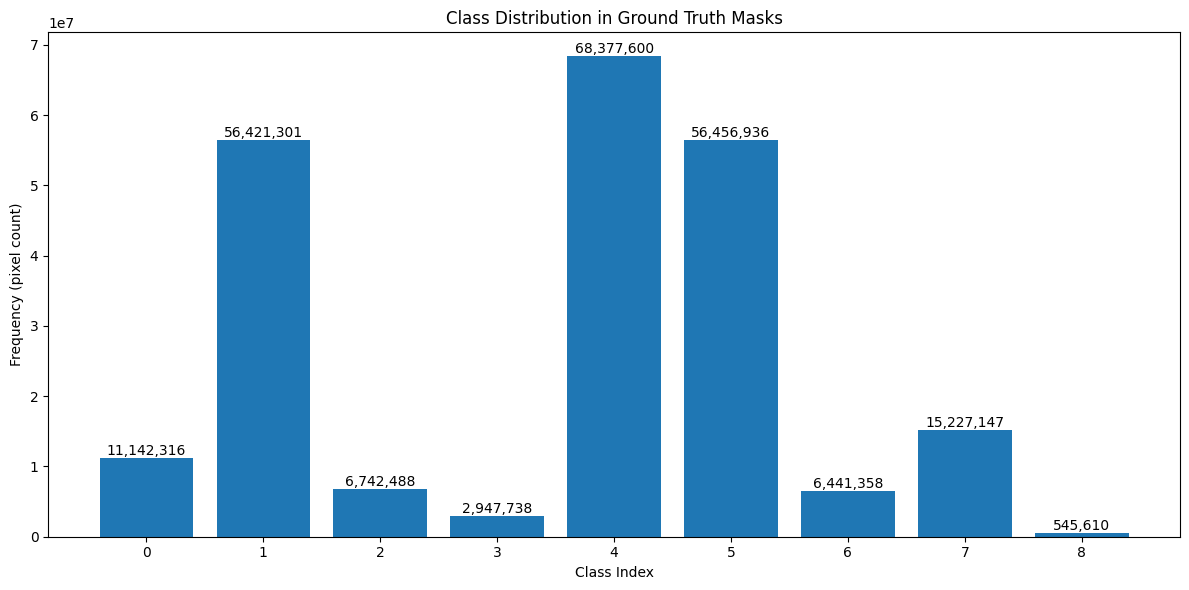


Class Distribution Summary:
Class 0: 11,142,316 pixels (4.97%)
Class 1: 56,421,301 pixels (25.15%)
Class 2: 6,742,488 pixels (3.01%)
Class 3: 2,947,738 pixels (1.31%)
Class 4: 68,377,600 pixels (30.48%)
Class 5: 56,456,936 pixels (25.17%)
Class 6: 6,441,358 pixels (2.87%)
Class 7: 15,227,147 pixels (6.79%)
Class 8: 545,610 pixels (0.24%)


In [4]:
dimensions, metrics = explore_labeled_shapes(labeled_images_path)
class_frequencies = analyze_class_distribution(labeled_images_path)

Based on the exploratory data analysis, the dataset presents two key challenges: varying image dimensions and significant class imbalance. To address these issues, I standardize all images to 1344x364 pixels, striking an optimal balance between computational efficiency and model performance. The uneven class distribution was mitigated through robust data augmentation techniques and specialized loss functions, which will be detailed in subsequent sections. Additionally, visual inspection revealed notable noise in the labeled data, likely stemming from inconsistencies in the annotation process, as mentioned in the discussion forum

## 1.2 Model Description

My approach builds upon the [UniMatch V2: Pushing the Limit of Semi-Supervised Semantic Segmentation](https://arxiv.org/abs/2410.10777) framework for semi-supervised semantic segmentation, focusing primarily on modernizing the model architecture. Instead of traditional ResNet encoders, we leverage the state-of-the-art [DINOv2](https://arxiv.org/abs/2304.07193) Vision Foundation Model as our encoder backbone, which benefits from self-supervised pretraining on extensive datasets. For the decoder component, we adopt the DPT Head from [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) as recommended in UniMatch V2, which has proven particularly effective for dense prediction tasks like semantic segmentation or depth estimation with ViT-based architectures. One key architectural enhancement is use of DINOv2 with registers checkpoint, following recent findings from [Vision Transformers Need Registers](https://arxiv.org/abs/2309.16588), which improves upon the original DINOv2 implementation used in UniMatch V2.

In detail, I use DINOv2 base variant. DPT takes as input multi-layer features (layers 3,6,9,12) from the DINOv2 encoder and generates dense predictions for semantic segmentation. The following figure illustrates the architecture and is borrowed from the original DPT paper.
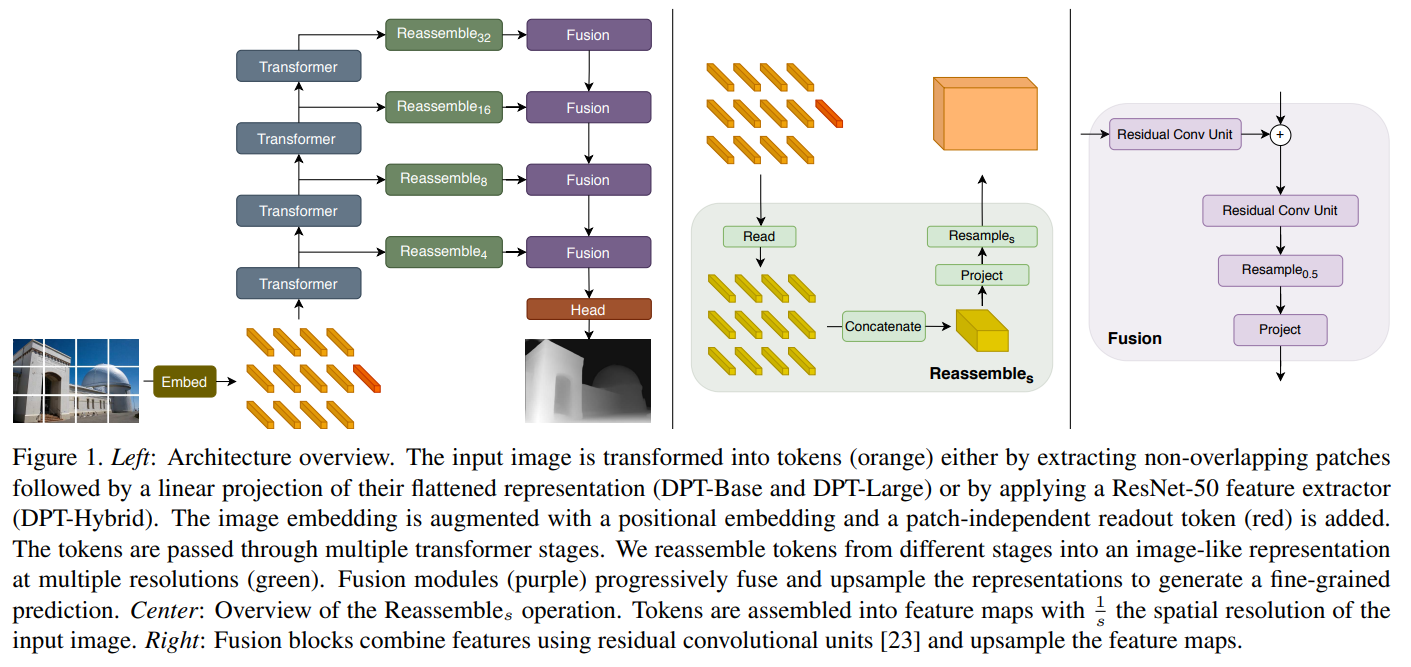

## 1.3 Training Strategy

The training procedure presented in UnimatchV2 involves a strategic enhancement of the UniMatch framework. This procedure underscores a shift from using traditional ResNet encoders to the more robust DINOv2 encoders, allowing for improved training outcomes with fewer parameters. Training adopts a semi-supervised approach which leverages both labeled and unlabeled data efficiently, using strategies like weak-to-strong consistency regularization and pseudo-labeling.
A critical aspect of this method is the dual-stream augmentation strategy, which unifies both image-level and feature-level augmentations into a single stream for increased training efficiency and performance. This is further augmented by the introduction of Complementary Dropout, a mechanism designed to yield two distinct yet complementary feature representations from augmented images, subsequently enhancing model robustness by improving the alignment between weakly and strongly augmented views.
The following image from the [UniMatch V2](https://arxiv.org/abs/2410.10777) paper illustrates the evolution of the training strategy.
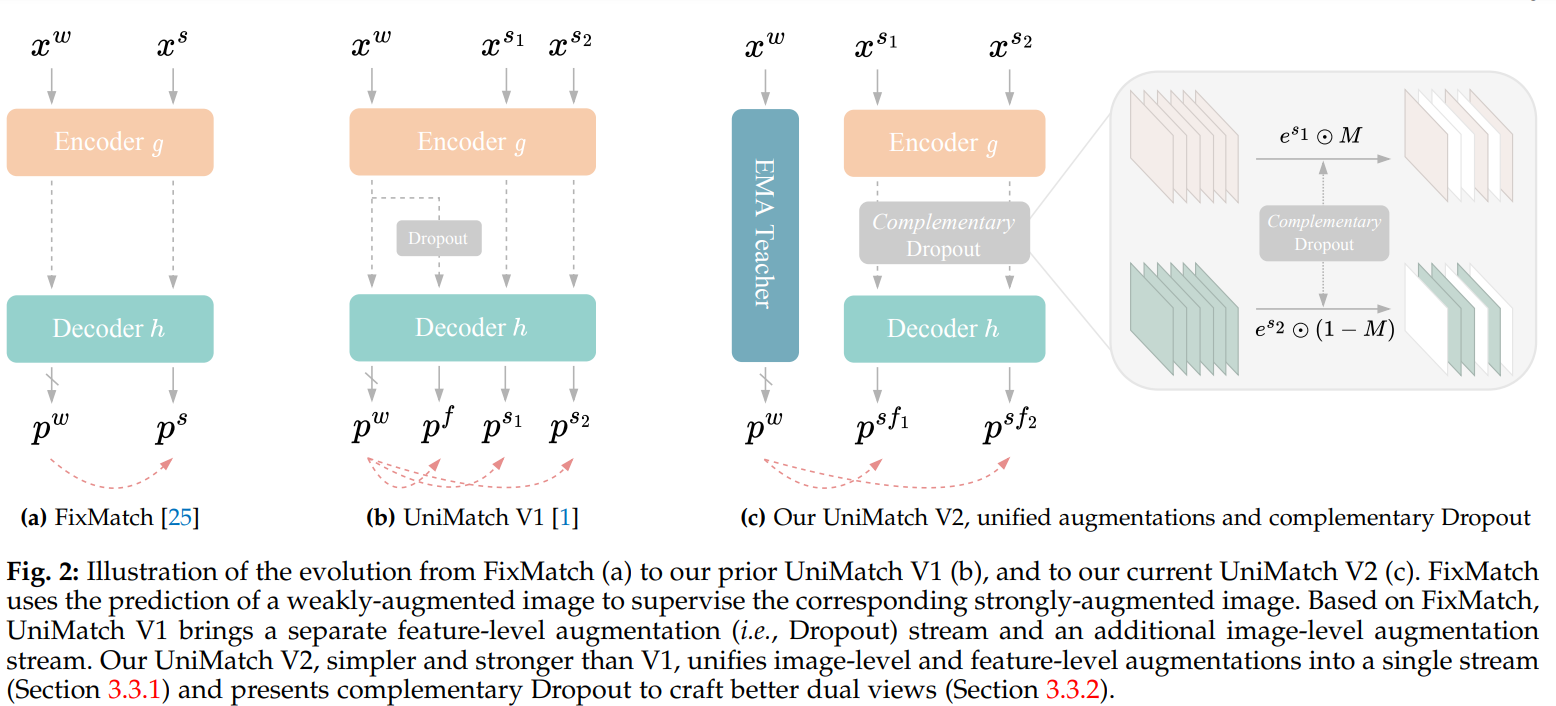

Some modifications were made to the original training strategy to better suit the dataset and task at hand. 
- In the original paper, training starts with un-trained head and uses exponential moving average (EMA) for the teacher at the end of each step. However this is very slow and not practical for this competition. To mitigate this, I first pretrain the head with frozen encoder for 10 epochs using only labeled data. Then I train the whole model with both labeled and unlabeled data (semi-supervised stage) and use EMA for the teacher at the end of each epoch.
- Run different experiments of the semi-supervised stage using different loss functions, like cross entropy, combined loss(cross entropy + dice) and the proposed loss in the original paper.
- Also run an experiment with concistency regularization on unlabaled data between the teacher and the student model.

## 1.5 Training Reproduction

### Stage 1: Pretrain the head with labeled data

#### Training Script Arguments

- `--image_size`: Input image dimensions as height,width (default: (1344,364))
- `--train_dir`: Directory containing training data (default: data/train)
- `--split_train_val`: Split training data into train (300 images) and validation (40 images) (default: False)
- `--seed`: Random seed for reproducibility (default: 1234)
- `--batch_size_train`: Training batch size (default: 16)
- `--lr`: Learning rate (default: 5e-4)
- `--epochs`: Number of training epochs (default: 10)
- `--accum_steps`: Number of steps for gradient accumulation (default: 1)
- `--mixed_precision`: Use mixed precision training (default: False)

The best checkpoint will be saved in the `checkpoints` directory with name `best_model_supervised.pth`.

To reproduce the checkpoint that will be used as starting point for stage 2 training use the default arguments

```bash
python train_model.py --mixed_precision 
```

In [ ]:
# Example Usage
!python train_model.py --mixed_precision 

Training images: 340
Validation images: 340
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
97,534,537 total parameters.
10,950,985 training parameters.
Epoch 1 Training: 100%|█| 21/21 [00:31<00:00,  1.50s/it, Loss=1.6719, LR=0.00048
Validation: 100%|████████████████| 340/340 [00:23<00:00, 14.74it/s, Loss=0.7773]
Epoch 1/10, Train Loss: 1.7303, Val Loss: 1.2859, Val dice: 0.3325, Learning

### Stage 2: Semi-Supervised Training with Labeled and Unlabeled Data

#### Training Script Arguments

- `--image_size`: Input image dimensions as height,width (default: (1344,364))
- `--train_dir`: Directory containing training data (default: data/train)
- `--unlabaled_train_dir`: Directory containing unlabeled training data (default: data/train_unlabeled)
- `--split_train_val`: Split training data into train (300 images) and validation (40 images) (default: False)
- `--seed`: Random seed for reproducibility (default: 1234)
- `--batch_size_train`: Training batch size (default: 16)
- `--blr`: Learning rate of backbone (default: 4e-5)
- `--lr`: Learning rate of head (default: 5e-4) 
- `--epochs`: Number of training epochs (default: 150)
- `--accum_steps`: Number of steps for gradient accumulation (default: 1)
- `--mixed_precision`: Use bfloat16 precision (default: False)
- `--loss_function`: Loss function to use [ce | combined | ohem] (default: ce)
- `--concistency_reg_unsup`: Use consistency regularization for unsupervised data (default: False)
- `--sp_model_ckpt`: Checkpoint path of supervised model to initialize the model (default: checkpoints/model_supervised.pth)

In case out of GPU Memory, you can reduce the batch size or use gradient accumulation by setting `--accum_steps` to a value greater than 1.
The best checkpoint will be saved in the `checkpoints` directory with name `best_model_semi.pth`

To reproduce the 5 final checkpoints use the following commands:

```bash
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised.pth" --blr 2e-5 # Produces checkpoint model_semi_blr2em5.pth
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised.pth" # Produces checkpoint model_semi.pth
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised.pth" --concistency_reg_unsup # Produces checkpoint model_semi_creg.pth
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised.pth" --loss_function combined # Produces checkpoint model_semi_combloss.pth
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised.pth" --epochs 100 --loss_function ohem # Produces checkpoint model_semi_ohem.pth
```
After training ends rename and move the checkpoints to the final checkpoints directory.(This is not necessary since I provide the final checkpoints)

A single training in an A100 GPU takes around 5hours for 150 epochs

In [ ]:
# Example Usage
!python train_model_semi.py --mixed_precision --sp_model_ckpt "checkpoints/model_supervised_head.pth" --batch_size 2 --accum_steps 8

## 1.6 Inference (Results reproduction with given checkpoints)

My inference strategy employs a sophisticated ensemble approach combining multiple techniques for optimal segmentation results. The pipeline begins with model ensemble prediction, where I average predictions from five top-performing model checkpoints stored in the `final_checkpoints` folder. Each model prediction incorporates Test Time Augmentation (TTA), applying four different transformations: original image, horizontal flip, vertical flip, and combined horizontal-vertical flip. These augmented predictions are averaged to produce more robust segmentation maps.
Following the initial predictions, I implement a two-stage refinement process. First, I employ the Segment Anything Model 2 (SAM2) using `SAM2AutomaticMaskGenerator` to generate high-quality segmentation masks. For each generated mask, I analyze the class distribution within the mask area from model's predictions and assign the majority class to the entire mask region. Since SAM2 masks may not cover the entire image, I retain the original predictions for uncovered areas. The prediction refinement script was adapted from [SegmentBooster](https://github.com/99eren99/SegmentBooster).
As a final refinement step, I implement a confidence-based selection mechanism. For areas where model ensemble predicts with high confidence (above a threshold of 0.625), I preserve the original predictions instead of using the SAM2-refined versions. This hybrid approach combines the strengths of both specialized model ensemble and SAM2's general segmentation capabilities.
Despite the complexity of the ensemble pipeline, the inference process is highly efficient, with a runtime of approximately 4 minutes on a single GPU of AWS EC2 g5.12xlarge instance.

#### Inference Script Arguments

- `--image_size`: Input image dimensions as height,width (default: (1344,364))
- `--test_dir`: Directory containing training data (default: data/core-values-test-data)
- `--checkpoints_folder`: Folder containing model checkpoints (default: final_checkpoints)
- `--sam2_abspath`: Absolute path to sam2 checkpoint (default: sam2)
- `--conf_threshold`: Confidence threshold for SAM2 (default: 0.625)
- `--save_visualisations`: Save visualisations (default: False)

To reproduce the final output use the following command (default arguments):
```bash
python predict.py --sam2_abspath "/home/ubuntu/cvs/sam2/checkpoints/sam2.1_hiera_large.pt"
```

If you want to create visualisations also use `--save_visualisations` argument. In this case, due to a problem with matplotlib it should be run through Command Line.

In [39]:
!python predict.py --sam2_abspath "/home/ubuntu/cvs/sam2/checkpoints/sam2.1_hiera_large.pt"

Number of test images: 70
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_main
Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dinov2_ma

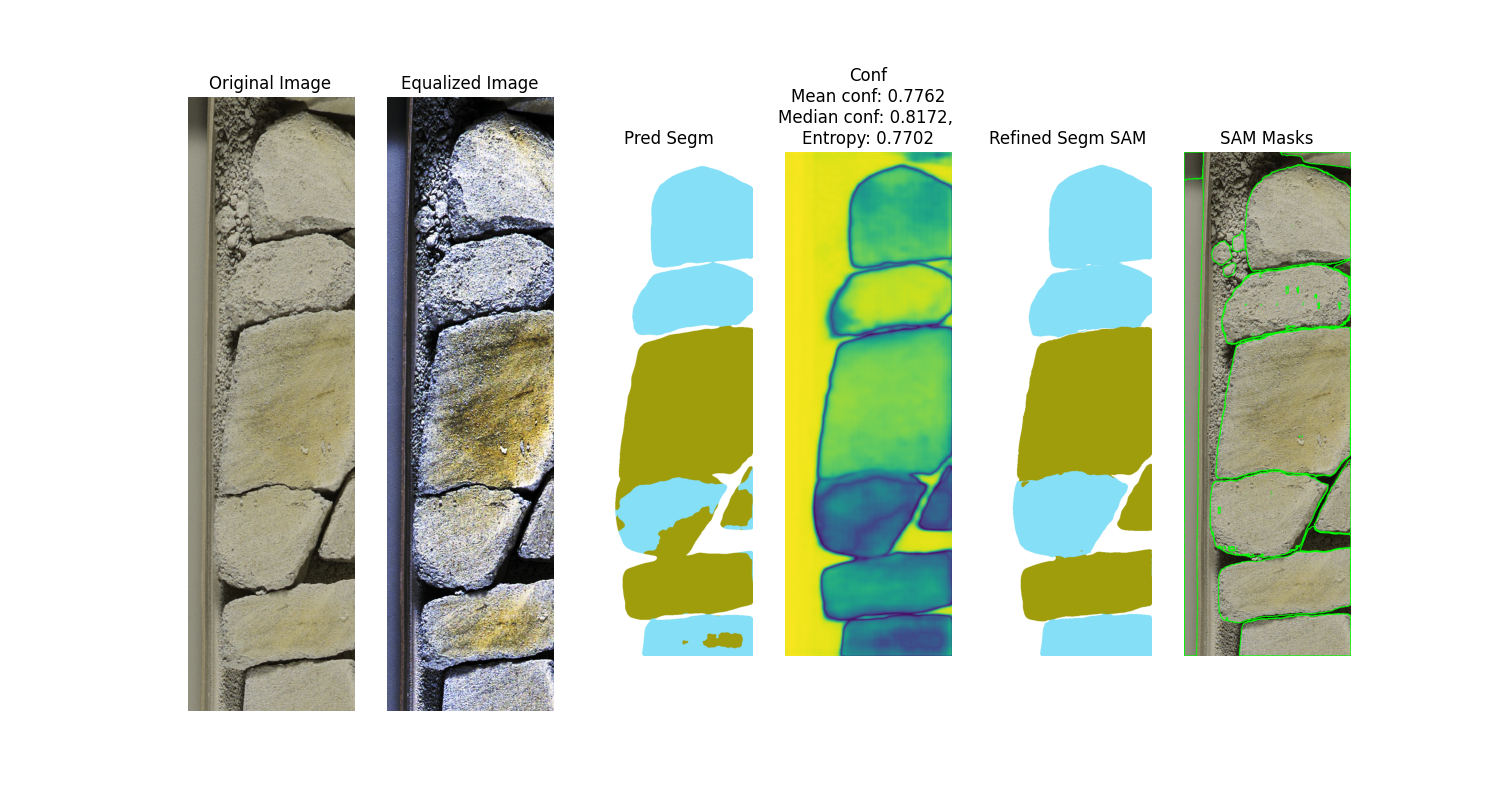

In [37]:
# Some Visualizations of the predictions
Image.open('pred_vis/15_img.png')

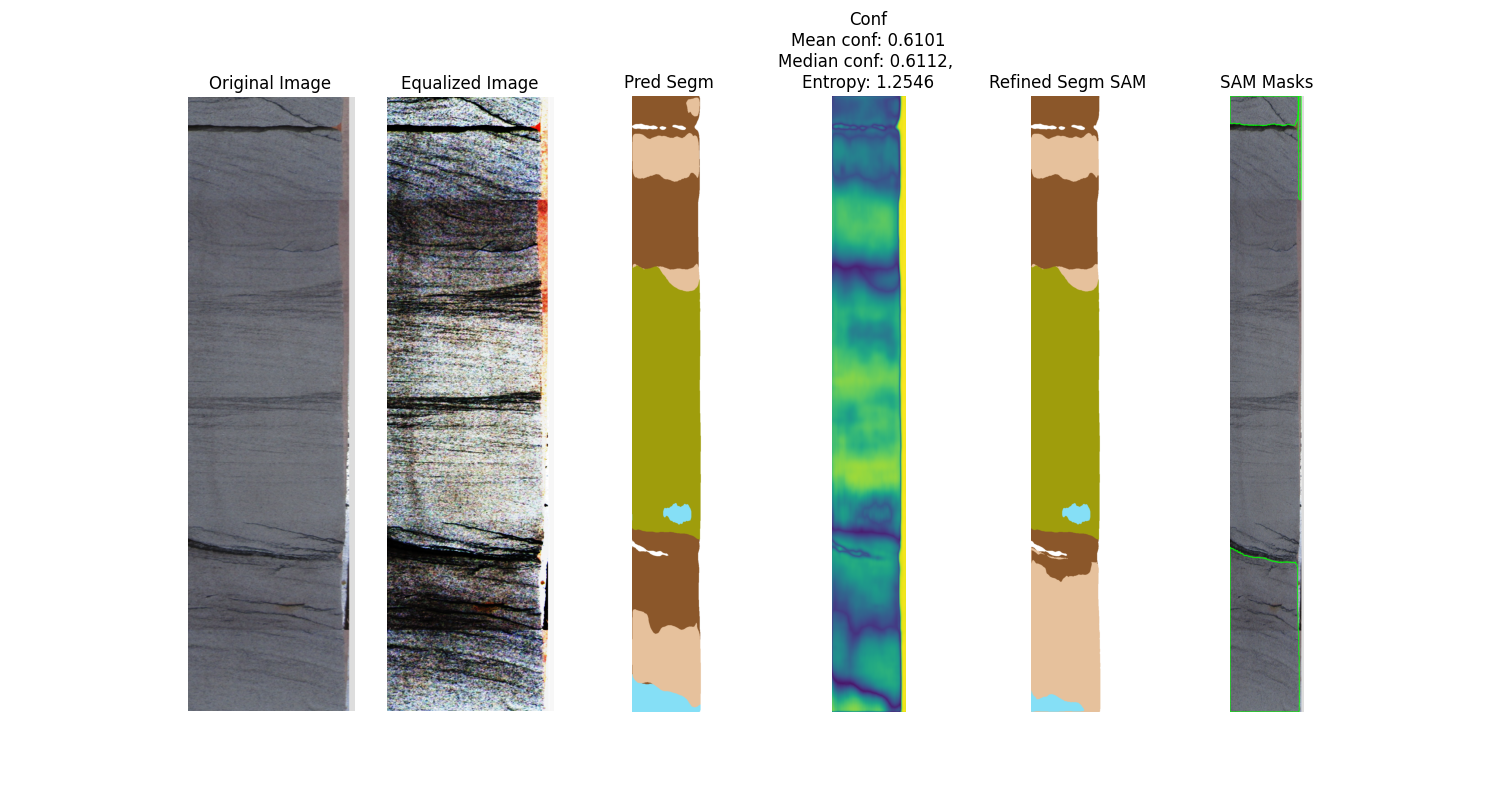

In [38]:
# Some Visualizations of the predictions
Image.open('pred_vis/29_img.png')

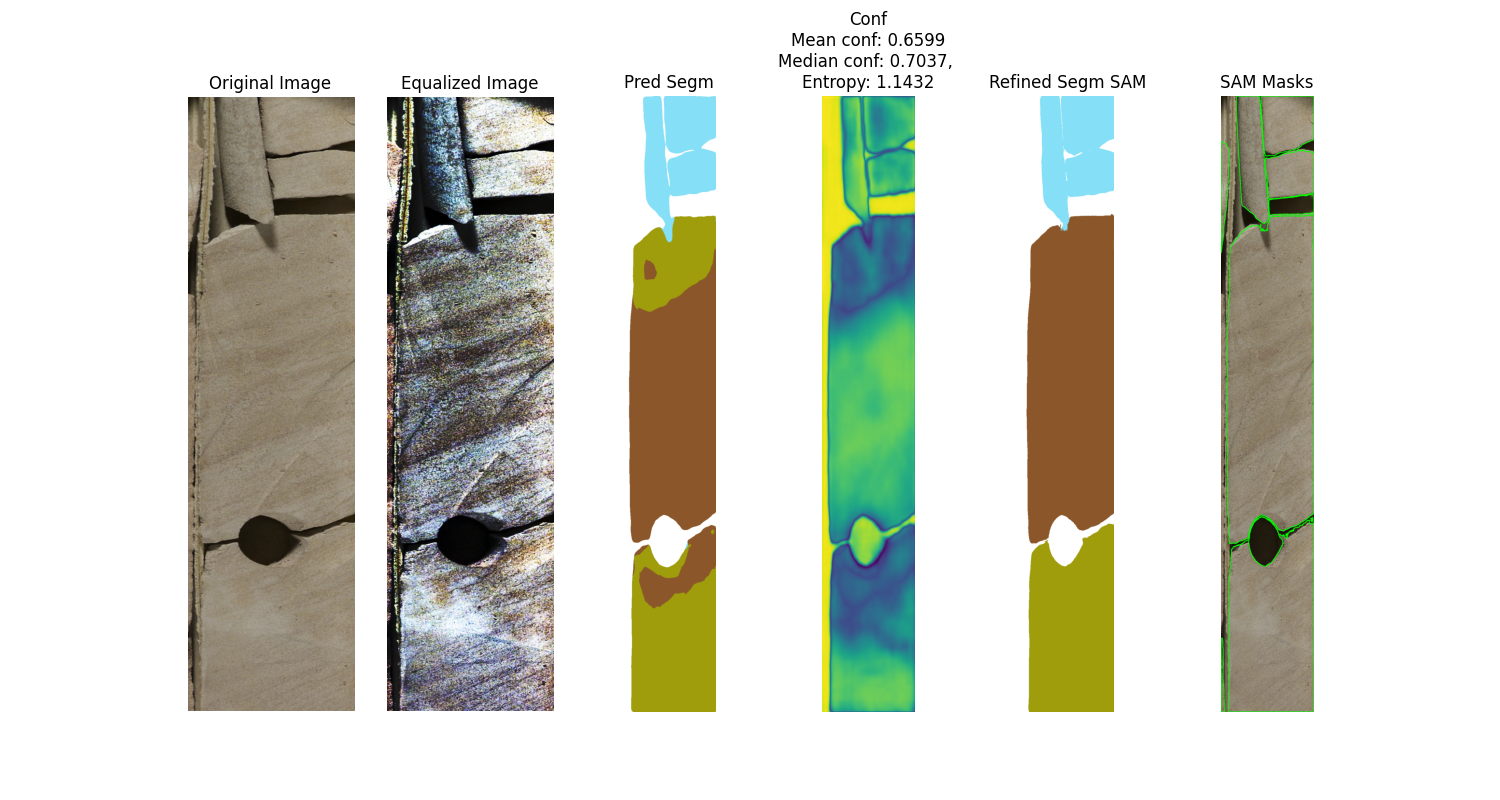

In [35]:
# Some Visualizations of the predictions
Image.open('pred_vis/70_img.png')